In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tslearn.metrics import dtw, soft_dtw
from sklearn.decomposition import PCA
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import statsmodels.api as sm
from tqdm import tqdm
from IPython.core.display import display, HTML
from tqdm import tnrange
from sklearn.manifold import TSNE
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import cross_val_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.signal import argrelmax
register_matplotlib_converters()

In [2]:
sns.set()

In [3]:
df = pd.read_csv('st_ts.txt', index_col='id')

In [4]:
df.columns =  pd.to_datetime(df.columns)

In [5]:
df = df[:60000]

In [6]:
df.shape

(60000, 105)

In [7]:
df.head()

,2017-08-28,2017-09-04,2017-09-11,2017-09-18,2017-09-25,2017-10-02,2017-10-09,2017-10-16,2017-10-23,2017-10-30,...,2019-06-24,2019-07-01,2019-07-08,2019-07-15,2019-07-22,2019-07-29,2019-08-05,2019-08-12,2019-08-19,2019-08-26
id,,,,,,,,,,,,,,,,,,,,,
0,3,0,2,2,6,1,1,0,3,0,...,6,4,5,1,0,1,0,0,0,0
1,0,0,0,0,2,1,2,1,1,0,...,1,1,0,0,0,0,1,0,1,0
2,0,0,0,0,2,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,1,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,2,0,0,1,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


Функция вычисления центроидов всех кластеров
Расстояние между цетроидами кластеров (на вход матрица цетроидов)
Функция вычисления среднего расстояния между кластерами

In [8]:
def centroids(data, clusters):
    n = np.unique(clusters)
    dist = []
    for i in n:
        matrix = data.values[np.where(clusters == i)]
        dist.append(np.sum(matrix, axis=0) / matrix.shape[0])
    return np.array(dist)


def cluster_dist(matrix):
    size = matrix.shape[0]
    av_dist = [sum((euclid(matrix[i], matrix[j]) for j in range(i, size))) for i in range(size)]
    return sum(av_dist)/ len(av_dist)


av_dist = lambda df, cl: cluster_dist(centroids(df, cl))


euclid = lambda x, y: np.sqrt(np.sum((x - y)**2))

In [12]:
def plot(*args):
    plt.figure(figsize=(20, 6), dpi=200)
    for arg in args:
        plt.plot(arg.T)
    plt.title('Data Example')
    plt.show()

s1 = [pd.datetime(2017, 9, 1), pd.datetime(2018, 9, 1)]
d31 = [pd.datetime(2017, 12, 31), pd.datetime(2018, 12, 31)]
f14 = [pd.datetime(2018, 2, 14), pd.datetime(2019, 2, 14)]
f23 = [pd.datetime(2018, 2, 23), pd.datetime(2019, 2, 23)]
m8 = [pd.datetime(2018, 3, 8), pd.datetime(2019, 3, 8)]
allhol = [s1, d31, f14, f23, m8]
    
def plot_clust(data, clusters, lines=100):
    centroid = centroids(data, clusters)
    n = np.unique(clusters)
    plt.figure(figsize=(20, 400))
    for i in n:
        plt.subplot(len(n), 1, i+1)
        plt.title(f'cluster {i}')
        for i in allhol:
            plt.axvline(i[0])
            plt.axvline(i[1])
        idx = np.where(clusters == i)[0][:lines]
        plt.plot(data.columns, centroid[i], c='red')
        for i in idx:
            plt.plot(data.T.iloc[:, i], c='black', alpha=0.1)
            plt.plot()

In [13]:
def metrics_values(data, clusters):
    metrics = {'Average Distance': av_dist(data, clusters),
                'Silhouette score': silhouette_score(data, clusters),
                'Calinski-Harabasz score': calinski_harabasz_score(data, clusters),
                'Davies bouldin score': davies_bouldin_score(data, clusters)}
    return metrics
    

In [14]:
scale = StandardScaler()
sc_df = pd.DataFrame(scale.fit_transform(np.log(1.1 + df).T).T, index=df.index, columns=df.columns)
sc_df.head()

,2017-08-28,2017-09-04,2017-09-11,2017-09-18,2017-09-25,2017-10-02,2017-10-09,2017-10-16,2017-10-23,2017-10-30,...,2019-06-24,2019-07-01,2019-07-08,2019-07-15,2019-07-22,2019-07-29,2019-08-05,2019-08-12,2019-08-19,2019-08-26
id,,,,,,,,,,,,,,,,,,,,,
0,0.837811,-1.467993,0.347821,0.347821,1.800155,-0.334740,-0.334740,-1.467993,0.837811,-1.467993,...,1.800155,1.220313,1.534106,-0.334740,-1.467993,-0.334740,-1.467993,-1.467993,-1.467993,-1.467993
1,-0.960348,-0.960348,-0.960348,-0.960348,1.317557,0.461298,1.317557,0.461298,0.461298,-0.960348,...,0.461298,0.461298,-0.960348,-0.960348,-0.960348,-0.960348,0.461298,-0.960348,0.461298,-0.960348
2,-0.731372,-0.731372,-0.731372,-0.731372,1.665273,0.764380,0.764380,-0.731372,0.764380,-0.731372,...,-0.731372,-0.731372,-0.731372,-0.731372,-0.731372,0.764380,-0.731372,-0.731372,-0.731372,-0.731372
3,-0.299183,2.144799,2.144799,-0.299183,-0.299183,-0.299183,3.616814,-0.299183,-0.299183,-0.299183,...,-0.299183,-0.299183,-0.299183,-0.299183,-0.299183,-0.299183,-0.299183,-0.299183,-0.299183,-0.299183
4,-0.387321,-0.387321,4.075234,-0.387321,-0.387321,2.397769,-0.387321,-0.387321,-0.387321,-0.387321,...,2.397769,2.397769,2.397769,2.397769,2.397769,2.397769,2.397769,2.397769,2.397769,2.397769


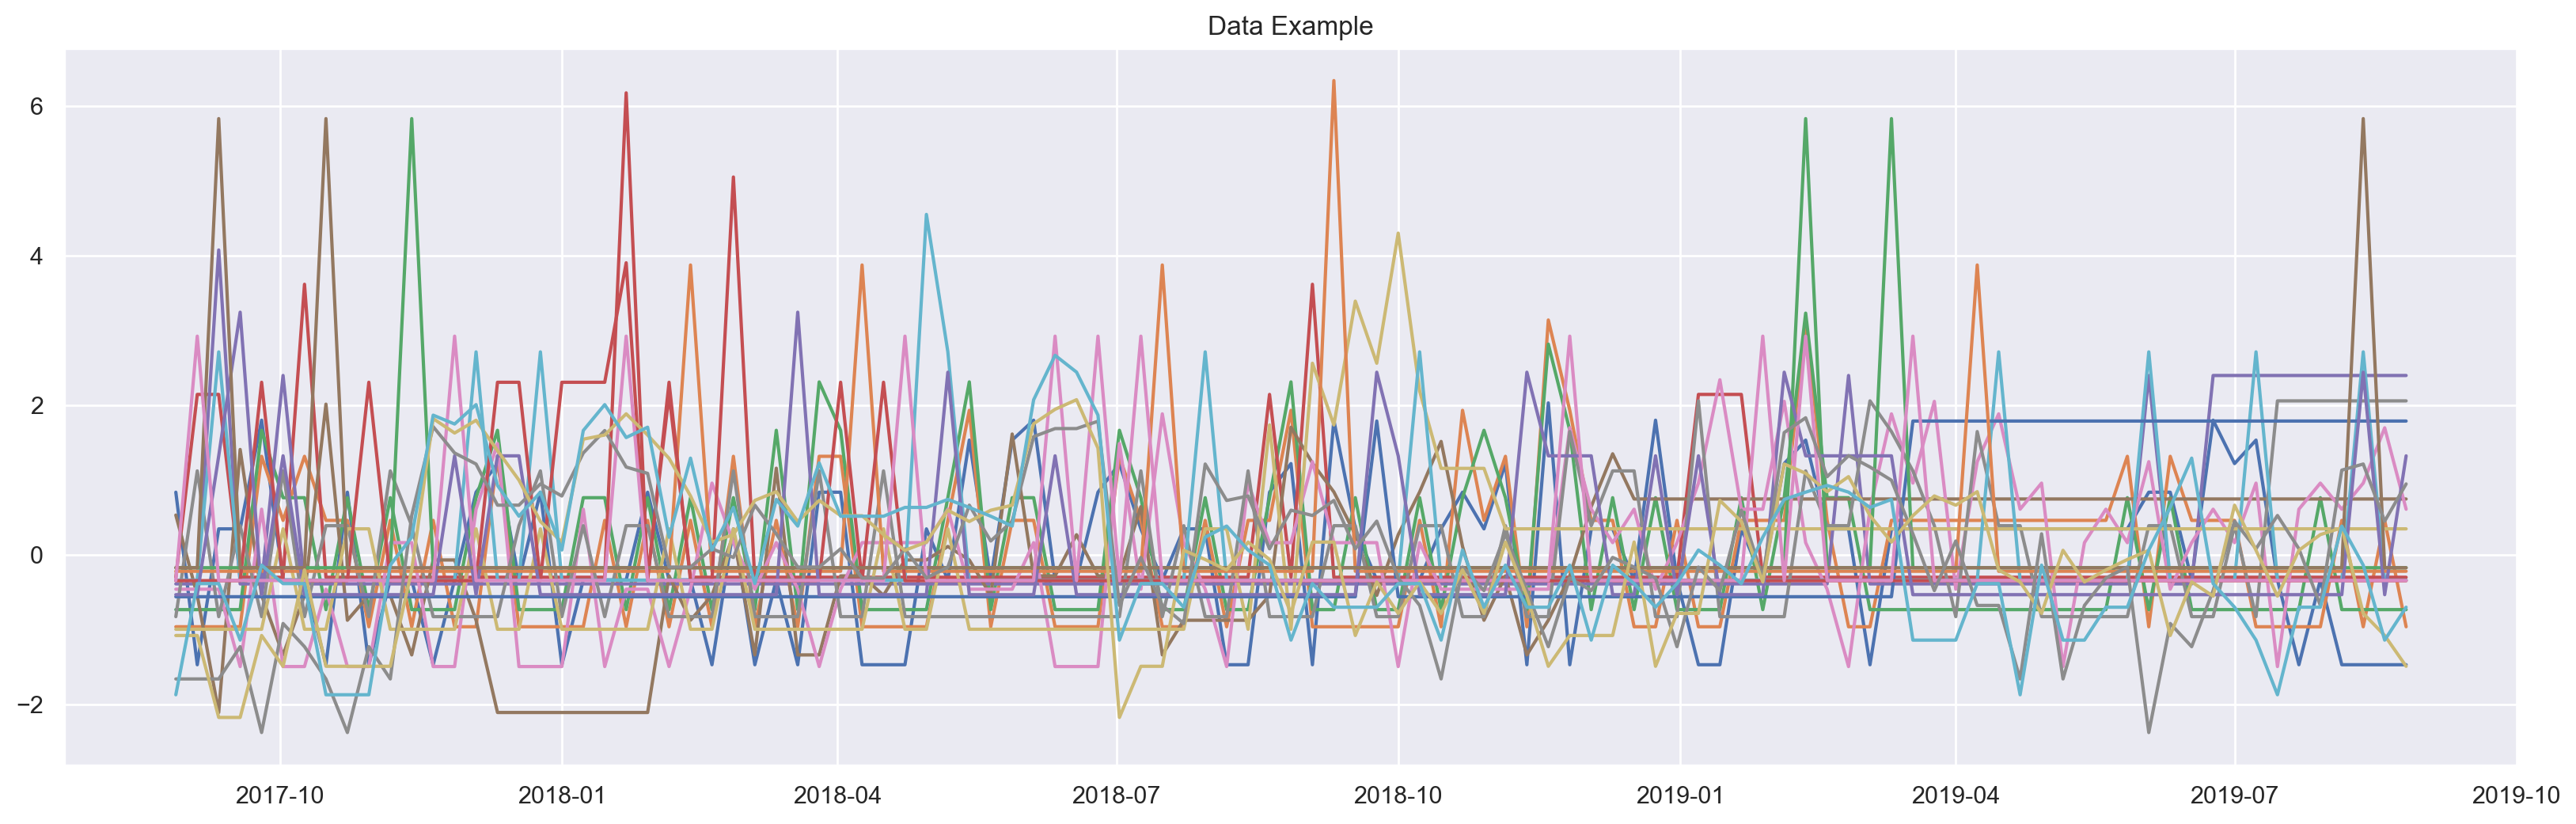

In [15]:
plot(sc_df[:20])

6     2442
28    2347
30    2311
25    1891
8     1836
27    1800
22    1790
1     1764
21    1747
20    1746
37    1687
15    1685
10    1672
34    1670
13    1653
3     1557
4     1532
29    1524
5     1482
23    1478
26    1462
32    1450
0     1435
7     1368
17    1304
33    1284
38    1284
14    1280
16    1276
12    1275
18    1270
11    1224
31    1212
9     1189
39    1167
19    1163
36    1154
24     971
2      834
35     784
dtype: int64


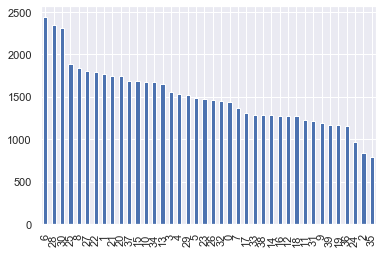

In [16]:
clusters = KMeans(n_clusters=40, random_state=42, n_jobs=-1).fit_predict(sc_df)
print(pd.Series(clusters).value_counts())
pd.Series(clusters).value_counts().plot.bar()
plt.show()

In [17]:
print(metrics_values(sc_df, clusters))

KeyboardInterrupt: 

/Users/artem/.local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

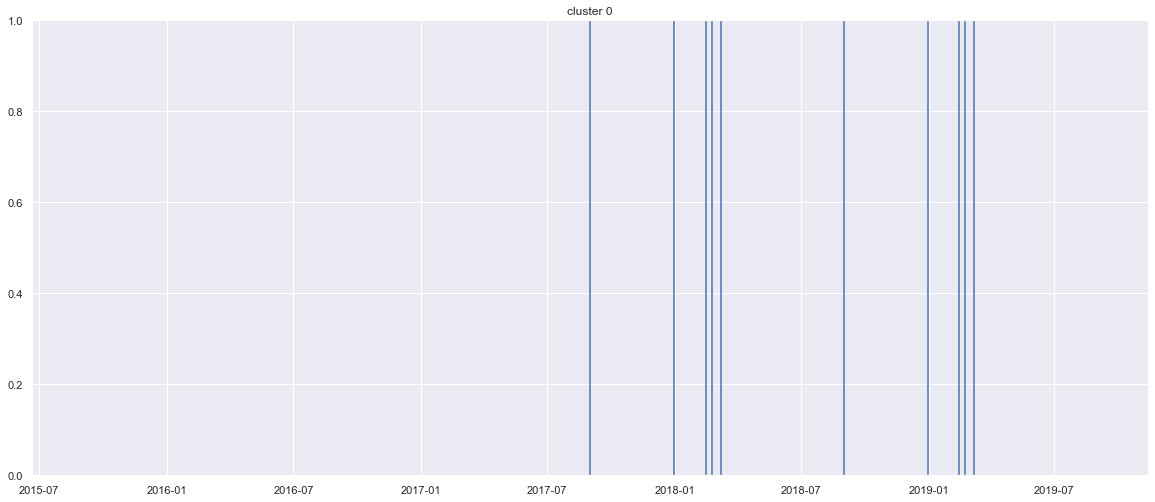

In [18]:
plot_clust(sc_df, clusters, 40)

In [ ]:
# for i in tnrange(2, 70):
#     pca = PCA(n_components=i, random_state=42)
#     red_df = pd.DataFrame(pca.fit_transform(sc_df))

#     clusters1 = KMeans(n_clusters=40, random_state=42).fit_predict(red_df)
#     print(i)
#     print(pd.Series(clusters1).value_counts())
#     print(av_dist(red_df, clusters1))

# pd.Series(clusters1).value_counts().plot.bar()
# plt.show()

In [ ]:
pca = PCA(n_components=2, random_state=42)
red_df = pd.DataFrame(pca.fit_transform(sc_df))

clusters1 = KMeans(n_clusters=40, random_state=42).fit_predict(red_df)
print(pd.Series(clusters1).value_counts())
print(av_dist(red_df, clusters1))

pd.Series(clusters1).value_counts().plot.bar()
plt.show()

In [18]:
print(metrics_values(sc_df, clusters1))

{'Average Distance': 124.69744183449079, 'Silhouette score': -0.05598396865498631, 'Calinski-Harabasz score': 312.59235548211115, 'Davies bouldin score': 9.615065013864008}


In [22]:
peaks = pd.DataFrame([sc_df.iloc[i][argrelmax(sc_df.iloc[i].values)[0]] for i in tnrange(sc_df.shape[0])])
peaks = peaks.fillna(0)

/Users/artem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  """Entry point for launching an IPython kernel.


0     7467
23    2731
25    2428
34    2334
29    2233
38    2202
32    2052
39    1960
1     1805
15    1707
28    1622
18    1615
20    1476
2     1437
36    1374
21    1373
26    1357
37    1353
22    1338
7     1323
35    1297
31    1275
17    1238
4     1200
30    1188
33    1150
19    1084
8     1073
11    1072
12    1017
16     870
9      779
24     760
3      728
5      715
6      712
10     691
14     662
27     662
13     640
dtype: int64


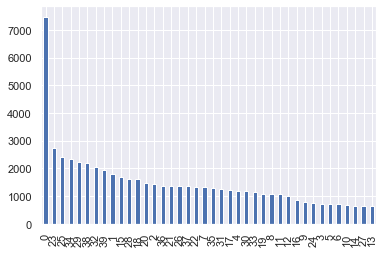

In [23]:
clusters2 = KMeans(n_clusters=40, random_state=42, n_jobs=-1, max_iter=200, verbose=10).fit_predict(peaks)
print(pd.Series(clusters2).value_counts())
pd.Series(clusters2).value_counts().plot.bar()
plt.show()

In [24]:
print(metrics_values(sc_df, clusters2))

{'Average Distance': 92.16261446378086, 'Silhouette score': -0.005638373036550641, 'Calinski-Harabasz score': 164.2290790891352, 'Davies bouldin score': 5.883960963086055}


In [ ]:
# df.iloc[1][argrelmax(df.iloc[1].values)[0]].nlargest(5)